- which subgraphs actually touch the final layer?
- which subgraphs actually touch the final layer and contain the correct class as a node in the subgraph?
- are nearest neighbors represented as nearest neighbors in graph space?
- what are the nearest neighbors of the additional graph structure induced by the adversary?

In [1]:
import os
import parse

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import dionysus as dion
import numpy as np
from scipy.spatial.distance import hamming, cosine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from pt_activation.functions.nnlayout import draw_neural_net
from pt_activation.models.cff import CFF

%load_ext autoreload
%autoreload 2

In [2]:
def get_adv_info(filename):
    format_string = 'true-{}_adv-{}_sample-{}.npy'
    parsed = parse.parse(format_string, filename)
    return {'true class':int(parsed[0]), 'adv class':int(parsed[1]), 'sample':int(parsed[2])}

def read_adversaries(loc):
    ret = []
    for f in os.listdir(loc):
        if os.path.isfile(os.path.join(loc,f)) and f.find('.npy') != -1:
            adv = np.load(os.path.join(loc, f))
            info = get_adv_info(f)
            info['adversary'] = adv
            ret.append(info)
    return ret
    

In [3]:
adv_directory_loc = '/home/tgebhart/projects/pt_activation/logdir/adversaries/fashion/carliniwagnerl2/cff_relu.pt'
adversaries = read_adversaries(adv_directory_loc)
adversaries = sorted(adversaries,  key=lambda k: k['sample'])

In [4]:
def create_filtrations(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../data/fashion', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
#                            transforms.Normalize((0.1307,), (0.3081,))
                       ])), batch_size=batch_size, shuffle=False, **kwargs)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    nms = []
    wms = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                # check if this makes sense
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=0, return_nm=True, absolute_value=True)
                row = {'filtration':f, 'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                nms.append(nm)
                wms.append(wm)

            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df), nms, wms

def create_adversary_filtrations(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    
    print(adv_images.shape)
    
    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    nms = []
    wms = []
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                # check if this makes sense
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=0, return_nm=True, absolute_value=True)
                row = {'filtration':f, 'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                nms.append(nm)
                wms.append(wm)

            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df), nms, wms

In [5]:
model_location = '/home/tgebhart/projects/pt_activation/logdir/models/fashion/cff_relu.pt'
model = CFF()
model.load_state_dict(torch.load(model_location))

In [6]:
res_df, nms, wms = create_filtrations(model, 50, 100)

Filtration: 0
filtration size 76133
Filtration: 1
filtration size 115796
Filtration: 2
filtration size 64539
Filtration: 3
filtration size 62512
Filtration: 4
filtration size 115404
Filtration: 5
filtration size 72257
Filtration: 6
filtration size 97477
Filtration: 7
filtration size 109862
Filtration: 8
filtration size 44537
Filtration: 9
filtration size 72798
Filtration: 10
filtration size 109812
Filtration: 11
filtration size 70375
Filtration: 12
filtration size 65519
Filtration: 13
filtration size 59214
Filtration: 14
filtration size 114743
Filtration: 15
filtration size 64884
Filtration: 16
filtration size 116471
Filtration: 17
filtration size 114105
Filtration: 18
filtration size 103550
Filtration: 19
filtration size 114378
Filtration: 20
filtration size 127343
Filtration: 21
filtration size 69933
Filtration: 22
filtration size 78348
Filtration: 23
filtration size 78274
Filtration: 24
filtration size 60892
Filtration: 25
filtration size 109018
Filtration: 26
filtration size 110338

In [7]:
adv_df, adv_nms, adv_wms = create_adversary_filtrations(model, 50, 100, adversaries)

torch.Size([4173, 1, 28, 28])
Filtration: 0
filtration size 116364
Filtration: 1
filtration size 115464
Filtration: 2
filtration size 111221
Filtration: 3
filtration size 113184
Filtration: 4
filtration size 115404
Filtration: 5
filtration size 111108
Filtration: 6
filtration size 102880
Filtration: 7
filtration size 111982
Filtration: 8
filtration size 122189
Filtration: 9
filtration size 121660
Filtration: 10
filtration size 111249
Filtration: 11
filtration size 118879
Filtration: 12
filtration size 118958
Filtration: 13
filtration size 121078
Filtration: 14
filtration size 114562
Filtration: 15
filtration size 115250
Filtration: 16
filtration size 120064
Filtration: 17
filtration size 118094
Filtration: 18
filtration size 114105
Filtration: 19
filtration size 114105
Filtration: 20
filtration size 116190
Filtration: 21
filtration size 112952
Filtration: 22
filtration size 127343
Filtration: 23
filtration size 69933
Filtration: 24
filtration size 120216
Filtration: 25
filtration size 

In [8]:
fashion_map = {
0:'Top',
1:'Trouser',
2:'Pullover',
3:'Dress',
4:'Coat',
5:'Sandal',
6:'Shirt',
7:'Sneaker',
8:'Bag',
9:'Boot'
}
labs = []
for i in range(res_df.shape[0]):
    labs.append(fashion_map[res_df.iloc[i]['prediction']])
res_df['label'] = labs
labs = []
for i in range(adv_df.shape[0]):
    labs.append(fashion_map[adv_df.iloc[i]['prediction']])
adv_df['label'] = labs

In [9]:
ids = [{v: k for k, v in nm.items()} for nm in nms]
adv_ids = [{v: k for k, v in nm.items()} for nm in adv_nms]

In [10]:
def create_sample_graphs(res_df, ids, wms):
    sample_graphs = []
    dgms = []
    lifetimes = []
    for s in range(res_df.shape[0]):
        print(s)
        wm = wms[s]
        tnms = ids[s]
        subgraphs = {}
        f = res_df['filtration'].iloc[s]
        m = dion.homology_persistence(f)
        dgm = dion.init_diagrams(m,f)[0]
        dgms.append(dgm)
        for i,c in enumerate(m):
            if len(c) == 2:
                w = f[i].data
                if (tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]) in wm:
                    w = wm[(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]])]
                elif (tnms[f[c[1].index][0]],tnms[f[c[0].index][0]]) in wm:
                    w = wm[(tnms[f[c[1].index][0]],tnms[f[c[0].index][0]])]
#                 else:
#                     print((tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]))
#                     raise Exception('NO WM!')
                if False: #tnms[f[c[0].index][0]] in subgraphs:
                    subgraphs[tnms[f[c[0].index][0]]].add_edge(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]], weight=w)
                else:
                    eaten = False
                    for k, v in subgraphs.items():
                        if v.has_node(tnms[f[c[0].index][0]]):
                            if tnms[f[c[1].index][0]] in subgraphs:
                                v.add_node(f[c[1].index][0])
#                                 subgraphs[k] = nx.union(v, subgraphs[tnms[f[c[1].index][0]]])
                            else:
                                v.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                            eaten = True
                            break
                    if not eaten:
                        g = nx.Graph()
                        g.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                        subgraphs[tnms[f[c[0].index][0]]] = g
                        
        sample_graphs.append(subgraphs)
        lifetimes.append(create_lifetimes(f, subgraphs,dgm,ids[s]))
    return sample_graphs, dgms, lifetimes

def create_lifetimes(f, subgraphs, dgm, ids):
    lifetimes = {}
    for pt in dgm:
        k = ids[f[pt.data][0]] 
        if k in subgraphs.keys():
            if pt.death < float('inf'):
                lifetimes[k] = pt.birth - pt.death
            else:
                lifetimes[k] = pt.birth
    return lifetimes
    

12
6
1*0 + 1*1
not eating
1*1 + 1*3
eating
1*6 + 1*7
not eating
1*3 + 1*6
eating
[3, 4] [0, 1, 2]
1*6 + 1*9
eating
dict_keys([0, 3])


/home/tgebhart/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


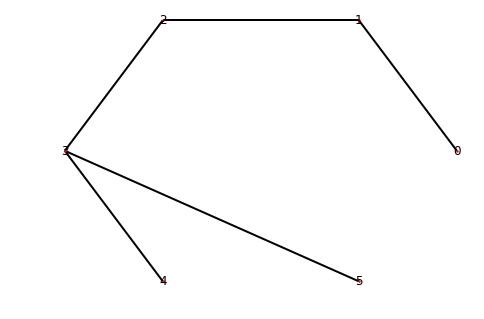

In [11]:
subgraphs = {}
simplices = [([2], 4.0),([1,2], 5.0),([0,2], 6.0),([0], 1.0),([1], 2.0),([0,1], 3.0),([3],7.0),([4],8.0),([3,4],9.0),([5],10.0),([3,5],12.0),([3,2],11.0)]
f = dion.Filtration(simplices)
f.sort()
m = dion.homology_persistence(f)
dgm = dion.init_diagrams(m,f)[0]
print(len(m))
print(len(dgm))
for i,c in enumerate(m):
    if len(c) == 2:
        print(c)
        if f[c[1].index][0] in subgraphs and f[c[0].index][0] in subgraphs:
            print('union')
            subgraphs[f[c[0].index][0]] = nx.union(subgraphs[f[c[0].index][0]],subgraphs[f[c[1].index][0]])
            subgraphs[f[c[0].index][0]].add_edge(f[c[0].index][0],f[c[1].index][0],weight=f[i].data)
        else:
            eaten = False
            for k, v in subgraphs.items():
                if v.has_node(f[c[0].index][0]):
                    print('eating')
                    if f[c[1].index][0] in subgraphs:
                        print(subgraphs[f[c[1].index][0]].nodes, v.nodes)
                        subgraphs[k] = nx.union(v, subgraphs[f[c[1].index][0]])
                    subgraphs[k].add_edge(f[c[0].index][0], f[c[1].index][0], weight=f[i].data)
                    eaten = True
                    break
            if not eaten:
                print('not eating')
                g = nx.Graph()
                g.add_edge(f[c[0].index][0], f[c[1].index][0], weight=f[i].data)
                subgraphs[f[c[0].index][0]] = g 
                
print(subgraphs.keys())
options = {
    'node_color': 'red',
    'node_size': 2,
    'width': 2,
    'with_labels':True}
nx.draw_circular(subgraphs[0], **options)


In [12]:
sample_graphs, dgms, lifetimes = create_sample_graphs(res_df, ids, wms)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [13]:
adv_sample_graphs, adv_dgms, adv_lifetimes = create_sample_graphs(adv_df, adv_ids, adv_wms)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [14]:
res_df.head(10)

,class,filtration,loss,prediction,label
0,9,"[(3516), (3523), (3516, 3523), (3486), (3525),...",-10.473322,9,Boot
1,2,"[(5100), (5128), (5100, 5128), (5080), (5132),...",-9.326435,2,Pullover
2,1,"[(3097), (3116), (3097, 3116), (3112), (3097, ...",-11.354310,1,Trouser
3,1,"[(2957), (2968), (2957, 2968), (2922), (2969),...",-12.957769,1,Trouser
4,6,"[(5109), (5138), (5109, 5138), (5085), (5140),...",-0.775915,0,Top
5,1,"[(3417), (3454), (3417, 3454), (3435), (3435, ...",-5.282070,1,Trouser
6,4,"[(4627), (4682), (4627, 4682), (4633), (4678),...",-5.450179,4,Coat
7,6,"[(4927), (4982), (4927, 4982), (4925), (4980),...",-6.778292,6,Shirt
8,5,"[(2030), (2062), (2030, 2062), (2048), (2048, ...",-5.003258,5,Sandal
9,7,"[(3233), (3265), (3233, 3265), (3214), (3269),...",-9.739986,7,Sneaker


In [15]:
adv_df.head(10)

,class,filtration,loss,prediction,label
0,9,"[(5147), (5154), (5147, 5154), (5107), (5157),...",-9.971922,7,Sneaker
1,2,"[(5089), (5143), (5089, 5143), (5087), (5141),...",-8.241382,6,Shirt
2,1,"[(5017), (5054), (5017, 5054), (5029), (5058),...",-0.695727,0,Top
3,1,"[(5050), (5097), (5050, 5097), (5096), (5050, ...",-7.727085,3,Dress
4,6,"[(5109), (5138), (5109, 5138), (5085), (5140),...",-0.775915,0,Top
5,1,"[(5016), (5053), (5016, 5053), (5028), (5057),...",-0.697690,0,Top
6,4,"[(4842), (4897), (4842, 4897), (4848), (4893),...",-4.969303,6,Shirt
7,6,"[(5017), (5072), (5017, 5072), (5015), (5070),...",-6.685757,4,Coat
8,5,"[(5239), (5271), (5239, 5271), (5257), (5257, ...",-4.525842,7,Sneaker
9,7,"[(5228), (5260), (5228, 5260), (5209), (5264),...",-8.956312,5,Sandal


In [16]:
goi = 2

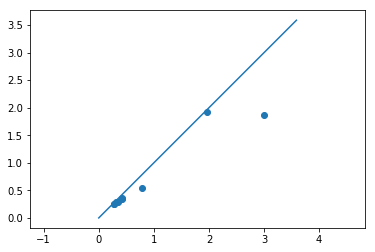

In [17]:
dion.plot.plot_diagram(dgms[goi])

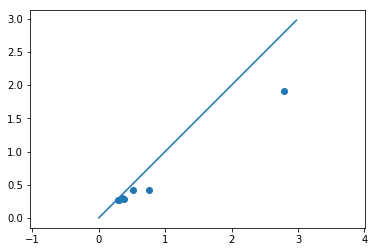

In [18]:
dion.plot.plot_diagram(adv_dgms[goi])

In [19]:
print(sample_graphs[goi].keys())

dict_keys([(2, 0, 36), (2, 0, 30), (2, 0, 47), (1, 0, 2320), (1, 0, 2848), (1, 0, 2867), (1, 0, 2480), (1, 0, 2528), (1, 0, 2632)])


In [20]:
print(adv_sample_graphs[goi].keys())

dict_keys([(2, 0, 18), (2, 0, 30), (1, 0, 2316), (1, 0, 2867), (1, 0, 2480), (1, 0, 2848), (1, 0, 2632), (1, 0, 2393)])


In [21]:
lifetimes[goi]

{(2, 0, 36): 3.587221384048462,
 (2, 0, 30): 1.1286863088607788,
 (2, 0, 47): 0.041913509368896484,
 (1, 0, 2320): 0.24082905054092407,
 (1, 0, 2848): 0.06376266479492188,
 (1, 0, 2867): 0.07104483246803284,
 (1, 0, 2480): 0.05294477939605713,
 (1, 0, 2528): 0.03198233246803284,
 (1, 0, 2632): 0.027395933866500854}

In [22]:
adv_lifetimes[goi]

{(2, 0, 18): 2.9772095680236816,
 (2, 0, 30): 0.8739376068115234,
 (1, 0, 2316): 0.33564338088035583,
 (1, 0, 2867): 0.10167241096496582,
 (1, 0, 2480): 0.0972318947315216,
 (1, 0, 2848): 0.04558223485946655,
 (1, 0, 2632): 0.025739818811416626,
 (1, 0, 2393): 0.016757190227508545}

In [23]:
sgk = (2,0,36)
asgk = (2,0,18)

In [24]:
# fig = plt.figure(figsize=(12, 12))
# draw_neural_net(fig.gca(), .1, .9, .1, .9, sample_graphs[goi][sgk], n_layers=4)

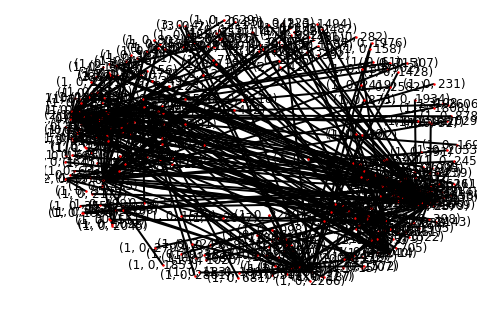

In [25]:
options = {
    'node_color': 'red',
    'node_size': 2,
    'width': 2,
    'with_labels':True}
nx.draw_spring(sample_graphs[goi][sgk], **options)

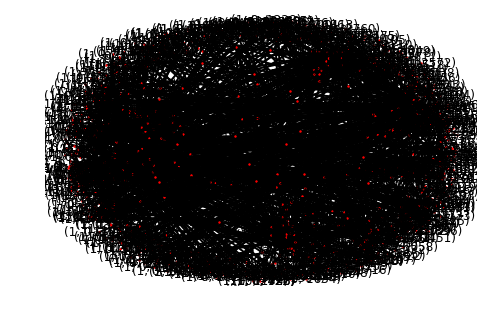

In [26]:
options = {
    'node_color': 'red',
    'node_size': 2,
    'width': 2,
    'with_labels':True}
nx.draw_spring(adv_sample_graphs[goi][asgk], **options)

In [27]:
sample_graphs[goi][sgk].edges(data=True)

EdgeDataView([((2, 0, 36), (3, 0, 5), {'weight': -3.5872214}), ((2, 0, 36), (3, 0, 1), {'weight': 3.3124995}), ((2, 0, 36), (3, 0, 6), {'weight': -2.7644155}), ((2, 0, 36), (1, 0, 2868), {'weight': -0.2222158}), ((2, 0, 36), (1, 0, 2511), {'weight': 0.21302007}), ((2, 0, 36), (1, 0, 2535), {'weight': 0.17524134}), ((2, 0, 36), (1, 0, 994), {'weight': 0.16403571}), ((2, 0, 36), (1, 0, 2626), {'weight': 0.15842894}), ((2, 0, 36), (1, 0, 2698), {'weight': 0.15099697}), ((2, 0, 36), (1, 0, 2844), {'weight': -0.14784375}), ((2, 0, 36), (1, 0, 737), {'weight': 0.1464664}), ((2, 0, 36), (1, 0, 736), {'weight': 0.10834552}), ((2, 0, 36), (1, 0, 898), {'weight': 0.10646895}), ((2, 0, 36), (1, 0, 2820), {'weight': -0.083203785}), ((2, 0, 36), (1, 0, 2792), {'weight': -0.06710427}), ((2, 0, 36), (1, 0, 660), {'weight': 0.059704043}), ((2, 0, 36), (1, 0, 995), {'weight': 0.05836588}), ((2, 0, 36), (1, 0, 2796), {'weight': -0.052479006}), ((2, 0, 36), (1, 0, 633), {'weight': -0.050639156}), ((2, 0,

In [28]:
adv_sample_graphs[goi][asgk].edges(data=True)

EdgeDataView([((2, 0, 18), (3, 0, 5), {'weight': -2.9772096}), ((2, 0, 18), (3, 0, 3), {'weight': 2.020387}), ((2, 0, 18), (3, 0, 8), {'weight': 1.8078998}), ((2, 0, 18), (1, 0, 2482), {'weight': 0.28429723}), ((2, 0, 18), (1, 0, 2481), {'weight': 0.25367856}), ((2, 0, 18), (1, 0, 2458), {'weight': 0.2217364}), ((2, 0, 18), (1, 0, 2577), {'weight': 0.19949113}), ((2, 0, 18), (1, 0, 2433), {'weight': 0.18065841}), ((2, 0, 18), (1, 0, 2410), {'weight': 0.1685627}), ((2, 0, 18), (1, 0, 2434), {'weight': 0.15596795}), ((2, 0, 18), (1, 0, 2720), {'weight': 0.13162099}), ((2, 0, 18), (1, 0, 2409), {'weight': 0.12610349}), ((2, 0, 18), (1, 0, 730), {'weight': 0.093097925}), ((2, 0, 18), (1, 0, 682), {'weight': 0.07218651}), ((2, 0, 18), (1, 0, 707), {'weight': 0.070943676}), ((2, 0, 18), (1, 0, 1495), {'weight': 0.07060981}), ((2, 0, 18), (1, 0, 658), {'weight': 0.060790587}), ((2, 0, 18), (1, 0, 1304), {'weight': 0.058963355}), ((2, 0, 18), (1, 0, 1280), {'weight': 0.054566152}), ((2, 0, 18)

In [29]:
def hamming_distance(g1, g2, ret_labels=False):
    nodeset = set(list(g1.nodes) + list(g2.nodes))
    g1_vec = np.zeros((len(nodeset)))
    g2_vec = np.zeros((len(nodeset)))
    nodesetlist = list(nodeset)
    for i in range(len(nodesetlist)):
        node = nodesetlist[i]
        if node in g1.nodes:
            g1_vec[i] = 1.0
        if node in g2.nodes:
            g2_vec[i] = 1.0
    if ret_labels:
        return hamming(g1_vec, g2_vec), nodesetlist
    else:
        return hamming(g1_vec, g2_vec)
    
def edge_hamming_distance(g1, g2, ret_labels=False):
    edgeset = set(list(g1.edges) + list(g2.edges))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in g1.edges:
            g1_vec[i] = 1.0
        if edge in g2.edges:
            g2_vec[i] = 1.0
    if ret_labels:
        return hamming(g1_vec, g2_vec), edgesetlist
    else:
        return hamming(g1_vec, g2_vec)
    
def lifetime_weighted_edge_distance(subgraphs1,subgraphs2,lifetimes1,lifetimes2,ret_labels=False):
    edges1 = {}
    edges2 = {}
    sg1keys = list(subgraphs1.keys())
    sg2keys = list(subgraphs2.keys())
    lifetimes1 = list(lifetimes1.values())
    lifetimes2 = list(lifetimes2.values())
    ml1 = max(lifetimes1)
    ml2 = max(lifetimes2)
    for i in range(len(sg1keys)):
        g = subgraphs1[sg1keys[i]]
        for e in g.edges:
            edges1[e] = lifetimes1[i]/ml1
    for i in range(len(sg2keys)):
        g = subgraphs2[sg2keys[i]]
        for e in g.edges:
            edges2[e] = lifetimes2[i]/ml2
    edgeset = set(list(edges1.keys()) + list(edges2.keys()))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in edges1:
            g1_vec[i] += edges1[edge]
        if edge in edges2:
            g2_vec[i] += edges2[edge]
    if ret_labels:
        return cosine(g1_vec, g2_vec), edgesetlist
    else:
        return cosine(g1_vec, g2_vec)
    
def weighted_edge_distance(g1, g2, ret_labels=False):
    edgeset = set(list(g1.edges) + list(g2.edges))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in g1.edges:
            g1_vec[i] = g1[edge[0]][edge[1]]['weight']
        if edge in g2.edges:
            g2_vec[i] = g2[edge[0]][edge[1]]['weight']
    if ret_labels:
        return cosine(g1_vec, g2_vec), edgesetlist
    else:
        return cosine(g1_vec, g2_vec)
    
def total_edge_weights(graphs):
    emap = {}
    for g in graphs:
        for e in g.edges:
            if e in emap:
                emap[e] += g[e[0]][e[1]]['weight']
            else:
                emap[e] = g[e[0]][e[1]]['weight']
    return emap

def count_nodes(graphs):
    nmap = {}
    for g in graphs:
        for n in g.nodes:
            if n in nmap:
                nmap[n] += 1.0
            else:
                nm[2] = 1.0
    return nmap

In [30]:
hamming_distance(sample_graphs[goi][sgk],adv_sample_graphs[goi][asgk])

0.6802395209580838

In [31]:
weighted_edge_distance(sample_graphs[goi][sgk],adv_sample_graphs[goi][asgk])

0.10041738895826724

In [32]:
adv_thru = -1
sim_mat = np.zeros((len(sample_graphs[goi]),len(adv_sample_graphs[goi])))
sk = list(sample_graphs[goi].keys())
ak = list(adv_sample_graphs[goi].keys())[:adv_thru]
for i in range(len(sk)):
    g = sample_graphs[goi][sk[i]]
    for j in range(len(ak)):
        ag = adv_sample_graphs[goi][ak[j]]
        sim_mat[i,j] = 1 - weighted_edge_distance(g,ag)
        

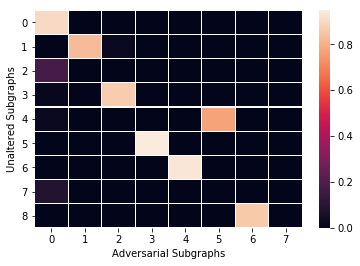

In [45]:
# ax = sns.heatmap(sim_mat[~np.all(sim_mat == 0, axis=1)], linewidths=.01)
ax = sns.heatmap(sim_mat, linewidths=.01)
plt.yticks(rotation=0)
plt.ylabel('Unaltered Subgraphs')
plt.xlabel('Adversarial Subgraphs')
plt.savefig('/home/tgebhart/projects/pt_activation/logdir/vis/cff_fashion/heatmap.png', format='png', dpi=500)

In [34]:
gois = [sample_graphs[goi][k] for k in sample_graphs[goi].keys()]
all_goi = nx.compose_all(gois)

In [35]:
adv_gois = [adv_sample_graphs[goi][k] for k in adv_sample_graphs[goi].keys()]
adv_all_goi = nx.compose_all(adv_gois)

In [36]:
# combs = []
# for sg in sample_graphs:
#     combs.append(nx.compose_all([sg[k] for k in sg.keys()]))
# adv_combs = []
# for sg in adv_sample_graphs:
#     adv_combs.append(nx.compose_all([sg[k] for k in sg.keys()]))

In [37]:
sorted_res_df = res_df.sort_values(by=['prediction'])
sorted_res_df.head()

,class,filtration,loss,prediction,label
85,0,"[(4866), (4917), (4866, 4917), (4911), (4866, ...",-0.022303,0,Top
20,2,"[(5318), (5373), (5318, 5373), (5352), (5371),...",-0.935775,0,Top
27,0,"[(3712), (3749), (3712, 3749), (3724), (3753),...",-0.381842,0,Top
88,0,"[(4721), (4772), (4721, 4772), (4766), (4721, ...",-0.013440,0,Top
96,0,"[(4727), (4778), (4727, 4778), (4772), (4727, ...",-0.282804,0,Top


In [38]:
# comb_sim_mat = np.zeros((len(combs),len(adv_combs)))
# for i in range(len(combs)):
#     g = combs[i]
#     for j in range(len(adv_combs)):
#         ag = adv_combs[j]
#         comb_sim_mat[i,j] = 1 - weighted_edge_distance(g,ag)

# comb_sim_mat = np.zeros((len(sample_graphs), len(adv_sample_graphs)))
# for i in range(len(sample_graphs)):
#     for j in range(len(adv_sample_graphs)):
#         comb_sim_mat[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[i],adv_sample_graphs[j],lifetimes[i],adv_lifetimes[j])

comb_sim_mat = np.zeros((len(sample_graphs), len(sample_graphs)))
sidx = list(sorted_res_df.index)
for i in range(len(sample_graphs)):
    ix = sidx[i]
    for j in range(len(sample_graphs)):
        jx = sidx[j]
        comb_sim_mat[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[ix],sample_graphs[jx],lifetimes[ix],lifetimes[jx])
        

In [39]:
csmdf = pd.DataFrame(comb_sim_mat, columns=sorted_res_df['label'], index=sorted_res_df['label'])

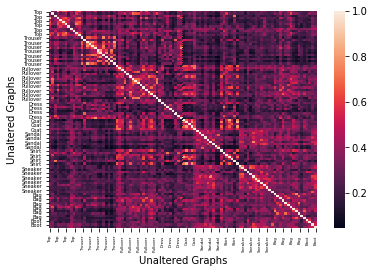

In [40]:
# ax = sns.heatmap(comb_sim_mat)
# plt.yticks(rotation=0)
# plt.ylabel('Unaltered Graphs')
# plt.xlabel('Adversarial Graphs')
# plt.savefig('comb_heatmap.png', format='png', dpi=500)

# ax = sns.heatmap(comb_sim_mat, xticklabels=sorted_res_df['prediction'],yticklabels=sorted_res_df['prediction'])
ax = sns.heatmap(csmdf, xticklabels=3, yticklabels=2)
plt.yticks(rotation=0)
plt.tick_params(axis='y',labelsize=5)
plt.tick_params(axis='x',labelsize=4)
plt.ylabel('Unaltered Graphs')
plt.xlabel('Unaltered Graphs')
plt.savefig('/home/tgebhart/projects/pt_activation/logdir/vis/cff_fashion/comb_heatmap_no_adv.png', format='png', dpi=500)

In [41]:
comb_sim_mat2 = np.zeros((len(sample_graphs), len(sample_graphs)))
for i in range(len(sample_graphs)):
    for j in range(len(sample_graphs)):
        comb_sim_mat2[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[i],sample_graphs[j],lifetimes[i],lifetimes[j])
    

In [42]:
ngoi = 7
res_df.iloc[ngoi].head()

class                                                         6
filtration    [(4927), (4982), (4927, 4982), (4925), (4980),...
loss                                                   -6.77829
prediction                                                    6
label                                                     Shirt
Name: 7, dtype: object

In [43]:
res_df.iloc[comb_sim_mat2[ngoi,:].argsort()[-10:][::-1]]

,class,filtration,loss,prediction,label
7,6,"[(4927), (4982), (4927, 4982), (4925), (4980),...",-6.778292,6,Shirt
6,4,"[(4627), (4682), (4627, 4682), (4633), (4678),...",-5.450179,4,Coat
99,2,"[(5078), (5133), (5078, 5133), (5076), (5131),...",-7.281294,2,Pullover
51,4,"[(4935), (4990), (4935, 4990), (4933), (4988),...",-5.777271,2,Pullover
44,6,"[(4948), (5003), (4948, 5003), (4946), (5001),...",-5.361562,6,Shirt
74,2,"[(4756), (4811), (4756, 4811), (4764), (4764, ...",-6.963335,2,Pullover
79,4,"[(5126), (5181), (5126, 5181), (5124), (5179),...",-9.175955,4,Coat
48,2,"[(4845), (4900), (4845, 4900), (4853), (4853, ...",-5.639839,2,Pullover
87,2,"[(4988), (5040), (4988, 5040), (4986), (5038),...",-8.274014,2,Pullover
10,4,"[(4950), (5005), (4950, 5005), (4948), (5003),...",-8.562779,4,Coat


In [44]:
res_df.iloc[comb_sim_mat2[0,:].argsort()[-10:][::-1]]

,class,filtration,loss,prediction,label
0,9,"[(3516), (3523), (3516, 3523), (3486), (3525),...",-10.473322,9,Boot
61,7,"[(3555), (3565), (3555, 3565), (3543), (3564),...",-13.594360,7,Sneaker
22,7,"[(3488), (3510), (3488, 3510), (3500), (3511),...",-16.759668,7,Sneaker
93,7,"[(3301), (3356), (3301, 3356), (3320), (3352),...",-17.029682,7,Sneaker
11,5,"[(3211), (3263), (3211, 3263), (3251), (3260),...",-8.258212,5,Sandal
70,7,"[(3615), (3670), (3615, 3670), (3655), (3666),...",-9.901893,7,Sneaker
28,9,"[(4108), (4152), (4108, 4152), (4138), (4149),...",-15.115400,9,Boot
23,9,"[(3522), (3553), (3522, 3553), (3543), (3543, ...",-11.400741,5,Sandal
38,7,"[(3623), (3655), (3623, 3655), (3604), (3659),...",-14.095764,7,Sneaker
63,5,"[(3311), (3342), (3311, 3342), (3332), (3332, ...",-7.812052,5,Sandal
